# Cloud Botany, see [paper]() and [instructions](https://howto.eurec4a.eu/botany_dales.html)

### Working with a downloaded 256x256 subset here, grabbed w/ other notebook 

In [19]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

In [140]:
ds_profiles = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_profiles.nc')
ds_profiles      #.wthvt[10][10].plot() # typical value 0.01

<xarray.Dataset>
Dimensions:  (member: 103, time: 720, zm: 175, zt: 175)
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * zm       (zm) float32 0.0 15.0 30.0 45.3 ... 6.772e+03 6.854e+03 6.938e+03
  * zt       (zt) float32 7.5 22.5 37.65 52.95 ... 6.813e+03 6.896e+03 6.98e+03
Data variables:
    wthvt    (member, time, zm) float32 ...
    ql       (member, time, zt) float32 ...
    ql2r     (member, time, zt) float32 ...
    cfrac    (member, time, zt) float32 ...
    w2r      (member, time, zm) float32 ...
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

# KE age (energy throughput, IBF) of each cloud scene

$ d/dt<[KE]> = <[w * dw/dt]> = <[wb]> $

$ = <  w' \cdot \theta_v' > g/ \theta_{v_0}  $

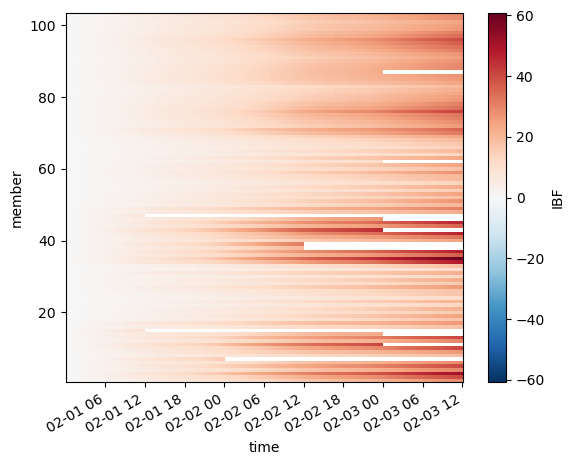

In [302]:
# Time integrate the vertical mean KE source from buoyancy flux

ds_profiles['IBF'] = ds_profiles.wthvt.mean('zm').cumulative_integrate('time','s') \
                        *g_over_th0
ds_profiles.IBF.plot() 

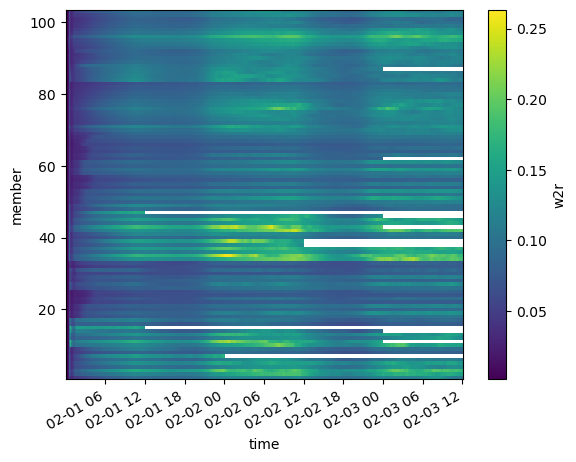

In [190]:
# Actual KE (w2r): implies ~1/4 hour bulk residence time...
# so there are ~100 turnovers per day in bulk KE 

ds_profiles.w2r.mean('zm').plot()  

-------------------
# 2D fields: make images with labels in filename 

In [191]:
ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256.nc')
ds_2D

<xarray.Dataset>
Dimensions:   (member: 103, time: 18, yt: 256, xt: 256)
Coordinates:
  * member    (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time      (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T08:45:00
  * xt        (xt) float64 50.0 650.0 1.25e+03 ... 1.518e+05 1.524e+05 1.530e+05
  * yt        (yt) float64 50.0 650.0 1.25e+03 ... 1.518e+05 1.524e+05 1.530e+05
Data variables:
    lwp       (member, time, yt, xt) float32 ...
    surfprec  (member, time, yt, xt) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

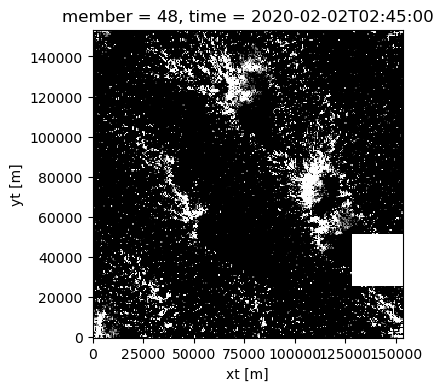

In [569]:
# square root of cloud water looks cloudlike 
# problem downloads: 1,9  31,11  34,8  47,8  61,3  69,4  74,7  81,4  83,4  86,4  91,5  missing squares 

np.sqrt(ds_2D.lwp[47][8]).plot(vmin=0, vmax=0.25, cmap='Greys_r', add_colorbar=False, size=4, aspect=1)
#plt.axis('off'); plt.title('');

plt.savefig("test.png", bbox_inches='tight')

## Loop to make image files with labels in filename
Browsed and removed all the bad ones (no cloud black, no data white, a few had missing squares??)

In [ ]:
for mem in ds_2D.member.values:
    for it in range(2,18): 
        
        filename = 'sim'+str(mem)+'_time'+str(it)+'_KEage_'+ "{:.2f}".format( \
                    ds_profiles.age_KE.sel(member=mem, time=ds_2D.time[it]).values)+'.png'

        # done print(mem, it, filename)
        
        np.sqrt(ds_2D.lwp[mem][it]).plot(vmin=0, vmax=0.25, cmap='Greys_r', add_colorbar=False, size=4, aspect=1)
        plt.axis('off'); plt.title('');
        plt.savefig('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/Images_cloudwater/'+filename, bbox_inches='tight')
        plt.close()

----------------
# Relating pattern information to age, KE-throughput
### are other factors important? accumulated precip? shear/isotropy?

What do I mean by pattern information? Deviations from maximum entropy (uniformity) of a PDF. But what PDF? Here I want to measure *spatial* nonuniformity of cloudiness at *coarse* scales, setting aside *total cloudiness* variations, across all the snapshots. For this reason, my PDF should be **the probability of being in the upper decile of LWP**, which can then be coarse-grained (block-averaged) to various resolutions. Of course IF CLOUD COVER IS LESS THAN 10%, this will just be the cloud cover itself. 

#### Structure of results arrays for correlating: 
information H, Integrated Buoyancy Flux IBF, Integrated Precip IP, age itself. 

H(member,age,octave) = Smax-S where S is entropy

IBF(member, age)

IP(member, age) = ds_2D.surfprec.sum(dims=['xt','yt'])

age(member, age) 

Q: Might the information at each coarse-grain scale add up to the total information, like variance in Parseval's theorem for orthogonal Fourier analysis? Need to study as math perhaps, will see in numbers here.

In [518]:
# predictors of information H to be examined 

ds_profiles['IP'] = ds_2D.surfprec.sum(dim=['xt','yt'])
ds_profiles['age'] = ds_profiles.time
# recalling from above in notebook 
ds_profiles['IBF'] = ds_profiles.wthvt.mean('zm').cumulative_integrate('time','s') \
                        *g_over_th0

In [380]:
def information(PDF): 
    # just make sure it is a PDF (sums to one) 
    PDF = PDF/np.sum(PDF)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99
    H = -np.log2(nullPDF) - (-np.sum( PDF * np.log2(PDF+1e-99)))
    
    return(H)

In [503]:
# Loop to compute pattern information H 

octaves = 2**np.linspace(0,7,8) # floats 2.,4,8,...128.

# Structure of results: 
NMEM = ds_2D.member.values.size
NT = 18
NOCT = octaves.size

Hs = np.zeros( (NMEM,NT,NOCT) )


for mem in range( ds_2D.member.size ):
    print('simulation ',mem)
    for it in range(2,18): 
        sq = ds_2D.lwp[mem][it]
        
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
        decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
        active = (sq > decile9)
        p_active = active/np.sum(active) # probability, because it sums to 1
        
# LOOP over coarsening blocks, resampled back onto 256x256 grid 
        for isc,scale in enumerate(octaves): 
            blocksize = int(scale)
            cp_active = p_active.coarsen(xt=blocksize, yt=blocksize).mean().\
                interp_like(active, method='nearest', kwargs={"fill_value": "extrapolate"})

# Collect the result: information H in bits, from the coarsened p_active array 
            Hs[mem,it,isc] = information(cp_active)

            if( Hs[mem,it,isc] < 0 ): 
                print('negative, what th? ',mem,it,isc, Hs[mem,it,isc] ) 
                stop
                
## Set Hs for problematic cases: all white, all black (uniform), or if quintile is zero
            if( np.isnan(sq).any() ):  # if any missing data nan
                Hs[mem,it,isc] = 0   # no information is present
            if( (sq == 0).sum() > 0.9*65536 ):      # if cloud fraction is < 10% 
                Hs[mem,it,isc] = 0   # declare it zero  

simulation  0
simulation  1
simulation  2
simulation  3
simulation  4
simulation  5
simulation  6
simulation  7
simulation  8
simulation  9
simulation  10
simulation  11
simulation  12
simulation  13
simulation  14
simulation  15
simulation  16
simulation  17
simulation  18
simulation  19
simulation  20
simulation  21
simulation  22
simulation  23
simulation  24
simulation  25
simulation  26
simulation  27
simulation  28
simulation  29
simulation  30
simulation  31
simulation  32
simulation  33
simulation  34
simulation  35
simulation  36
simulation  37
simulation  38
simulation  39
simulation  40
simulation  41
simulation  42
simulation  43
simulation  44
simulation  45
simulation  46
simulation  47
simulation  48
simulation  49
simulation  50
simulation  51
simulation  52
simulation  53
simulation  54
simulation  55
simulation  56
simulation  57
simulation  58
simulation  59
simulation  60
simulation  61
simulation  62
simulation  63
simulation  64
simulation  65
simulation  66
simul

In [446]:
ds_profiles

<xarray.Dataset>
Dimensions:  (member: 103, time: 720, zm: 175, zt: 175)
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * zm       (zm) float32 0.0 15.0 30.0 45.3 ... 6.772e+03 6.854e+03 6.938e+03
  * zt       (zt) float32 7.5 22.5 37.65 52.95 ... 6.813e+03 6.896e+03 6.98e+03
Data variables:
    wthvt    (member, time, zm) float32 0.02832 0.02508 ... -1.964e-06
    ql       (member, time, zt) float32 ...
    ql2r     (member, time, zt) float32 ...
    cfrac    (member, time, zt) float32 ...
    w2r      (member, time, zm) float32 0.0 5.471e-05 ... 5.767e-05 1.475e-05
    age_KE   (member, time) float64 0.0 0.003413 0.01319 ... 29.24 29.29 29.33
    IBF      (member, time) float64 0.0 0.003413 0.01319 ... 29.24 29.29 29.33
    IP       (member, time) float32 0.0 nan nan nan nan ... nan nan nan nan nan
    age      (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

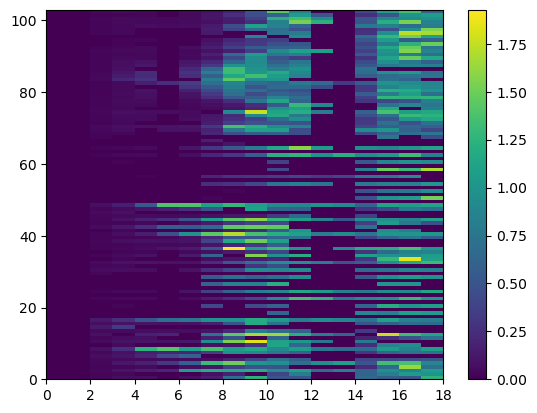

In [504]:
plt.pcolormesh( Hs[:,:,4] ); plt.colorbar()

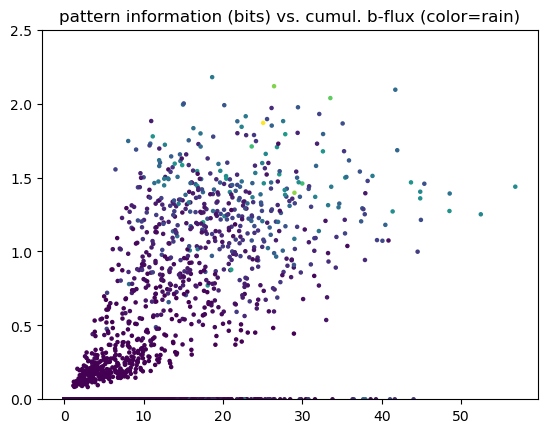

In [628]:
plt.scatter( ds_profiles.IBF.sel(time = ds_2D.time), Hs[:,:,3], \
            c=ds_profiles.IP.sel(time = ds_2D.time), \
            s=5)
plt.ylim([0,2.5])
plt.title('pattern information (bits) vs. cumul. b-flux (color=rain)');

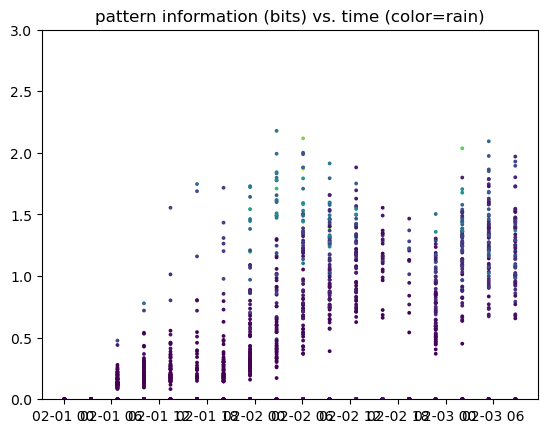

In [625]:
plt.scatter( np.meshgrid(ds_profiles.time.sel(time = ds_2D.time),ds_profiles.member)[0], \
            Hs[:,:,3], c=ds_profiles.IP.sel(time = ds_2D.time), s=3)
plt.ylim([0,3])
plt.title('pattern information (bits) vs. time (color=rain)');

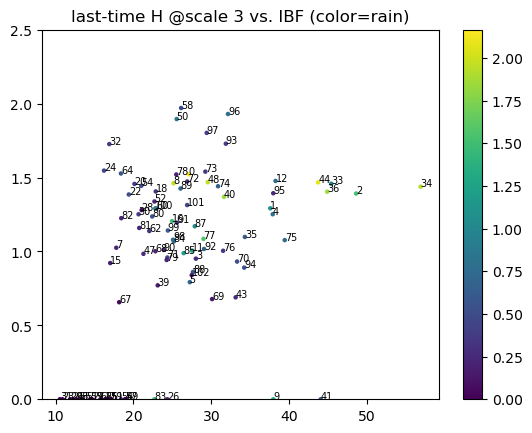

In [648]:
# Final time level, annotate with experiment number

plt.scatter( ds_profiles.IBF.sel(time = ds_2D.time)[:,-1], Hs[:,-1,3], \
            c=ds_profiles.IP.sel(time = ds_2D.time)[:,-1], s=5) 

xxx = ds_profiles.IBF.sel(time = ds_2D.time)[:,-1]
yyy = Hs[:,-1,3]
m=np.array( range(103) ).astype(str)

for iii in range(103):
    plt.annotate(m[iii], [xxx[iii],yyy[iii]], size=7)

plt.ylim([0,2.5])
plt.colorbar()
plt.title('last-time H @scale 3 vs. IBF (color=rain)');

In [52]:
df_parameters.iloc[ [2,9,32,33,34,35,36] ]  # from other CloudBotany notebook on server

,member,thls,u0,qt0,qt_lambda,thl_Gamma,wpamp,dudz,location
2,3,297.5,-15.0,0.0135,1200.0,4.5,0.0018,0.0022,corner
9,10,297.5,-15.0,0.0150,1200.0,4.5,-0.0035,0.0022,corner
32,33,297.5,-5.0,0.0150,2500.0,5.5,0.0018,0.0022,corner
33,34,299.5,-15.0,0.0135,1200.0,4.5,-0.0035,0.0022,corner
34,35,299.5,-15.0,0.0135,1200.0,4.5,0.0018,0.0022,corner
35,36,299.5,-15.0,0.0135,1200.0,5.5,-0.0035,0.0022,corner
36,37,299.5,-15.0,0.0135,1200.0,5.5,0.0018,0.0022,corner


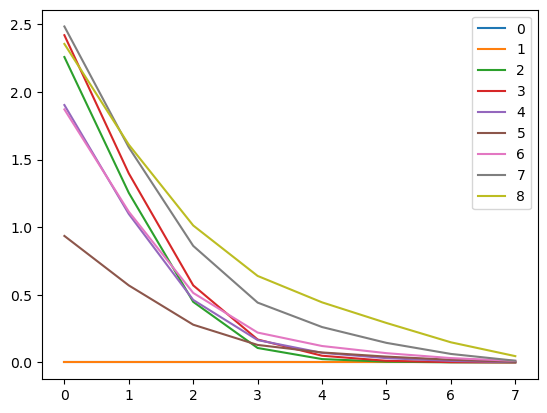

In [614]:
# information spectrum by scale, *averaged over members* (18 times)
labels = np.array( range(9) ).astype(str)

Hspectra = Hs.mean(0).transpose()
plt.plot(Hspectra[:,0:9], label=labels );
plt.legend(loc='upper right')

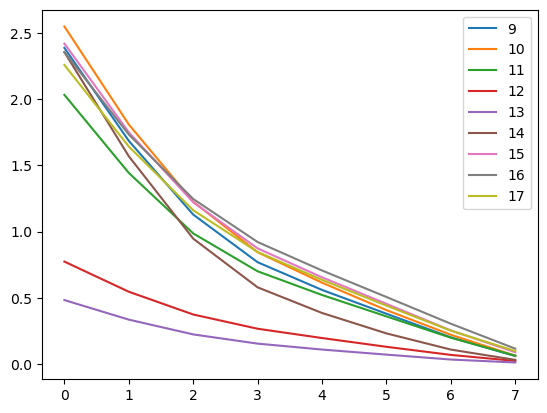

In [622]:
# information spectrum by scale, *averaged over members* (18 times)
labels = (np.array( range(9) )+9).astype(str)

Hspectra = Hs.mean(0).transpose()
plt.plot(Hspectra[:,9:], label=labels );
plt.legend(loc='upper right')

In [630]:
np.array( range(103) ).astype(str)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102'], dtype='<U21')

In [621]:
np.array( range(9) )+9

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [638]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle

# Generate some sample data
x = np.random.rand(10)
y = np.random.rand(10)

# Define a custom marker using the string '23'
custom_marker = MarkerStyle('23')

# Create a scatter plot with the custom marker
plt.scatter(x, y, marker=custom_marker, s=100, label='Custom Marker "23"')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()


ValueError: Unrecognized marker style '23'

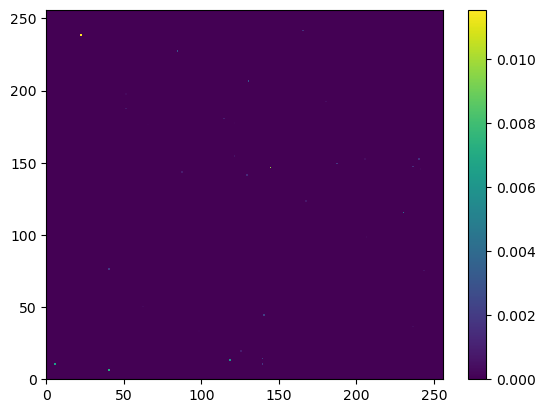

In [491]:
np.where(Hs > 4) # use this to find cases 

mem=17
it=5
sq = ds_2D.lwp[mem][it]
plt.pcolormesh(sq); plt.colorbar()

<xarray.DataArray 'lwp' ()>
array(10.91253716)
Coordinates:
    member   int32 18
    time     datetime64[ns] 2020-02-01T16:45:00

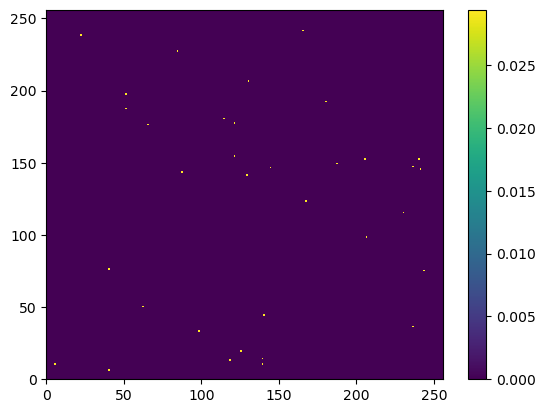

In [495]:
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
active = (sq > decile9)
p_active = active/np.sum(active) # probability, because it sums to 1

plt.pcolormesh(p_active); plt.colorbar()
# LOOP over coarsening blocks, resampled back onto 256x256 grid 
information(p_active)


In [497]:
PDF = p_active
PDF = PDF/np.sum(PDF)

# information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
nullPDF = 1./ np.size(PDF)

# for log2, need to make sure the zeros are replaced with 1e-99
H1 = -np.log2(nullPDF) 
H2 = (-np.sum( PDF * np.log2(PDF+1e-99)))

print(H1,H2.values)

16.0 5.087462841250338


In [502]:
(sq == 0).sum() #65502/65536

<xarray.DataArray 'lwp' ()>
array(65502)
Coordinates:
    member   int32 18
    time     datetime64[ns] 2020-02-01T16:45:00

# other morphometrics besides entropy? 
### maybe someday 

To compute cloud scene morpho metrics, follow [this repo](https://github.com/martinjanssens/cloudmetrics) and do 

`import cloudmetrics`

`iorg = cloudmetrics.iorg(cloud_mask=da_cloudmask)`

In [515]:
# Create 1D coordinate values for each dimension
x_values = np.linspace(0, 10, 5)
y_values = np.linspace(0, 5, 3)

# Create a 2D array of 1D coordinate values
data_array = xr.DataArray(np.random.rand(len(x_values), len(y_values)),
                          coords={'x': x_values, 'y': y_values},
                          dims=['x', 'y'])

# Get a 2D array of x coordinate values
#x_2d_array = data_array['x'].values

x_2d_array = np.meshgrid(data_array['x'].values, data_array['y'].values)[0]

# Print the resulting 2D array
print(x_2d_array)

[[ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]]


In [510]:
%history

import eurec4a
cat = eurec4a.get_intake_catalog()
botany_cat = cat.simulations.DALES.botany
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")
cat
list(cat)
botany_cat = cat.simulations.DALES.botany
botany_cat
botany_cat?
botany_cat.dx100m
botany_cat.dx100m.nx1536
botany_cat.dx100m.nx1536.2D
botany_cat.dx100m.nx1536
import pandas as pd
varied_parameters = ['member','thls', 'u0', 'qt0', 'qt_lambda', 'thl_Gamma', 'wpamp', 'dudz', 'location']
parameters = cat.simulations.DALES.botany.dx100m.nx1536.parameters.read()
df_parameters = pd.DataFrame.from_records(parameters)[varied_parameters]
df_parameters
parameters
import xarray as xr

ds_profiles = botany_cat.dx100m.nx1536['profiles'].to_dask()
ds_profiles
ds_2D = botany_cat.dx100m.nx1536['2D'].to_dask()
ds_2D = botany_cat.dx100m.nx1536['2D'].to_dask()
ds_2D
from cycler import cycler

fig = plt.figure()
ax = plt.gca()
ax.set_prop_cycle(cycler(color=plt.cm.cividis(